In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import triton
import original_quant
import quant

## Verify corectness

In [3]:
M = 4096

torch.manual_seed(0)
layer = nn.Linear(M, M)
vec = torch.randn(1, 2048, M, device='cuda', dtype=torch.float16)

quantizer = original_quant.Quantizer()
quantizer.configure(4, perchannel=True, sym=False, mse=False)
quantizer.find_params(layer.weight.data, weight=True)
layer.weight.data = original_quant.quantize(layer.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq)

cudalayer = original_quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
cudalayer.pack(layer, quantizer.scale, quantizer.zero)

tritonlayer = quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
state_dict = cudalayer.state_dict()
state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
state_dict['bias'] = state_dict['bias'].to(torch.float16, copy=True)
tritonlayer.load_state_dict(state_dict)

layer = layer.half()

layer = layer.to('cuda')
cudalayer = cudalayer.to('cuda')
tritonlayer = tritonlayer.to('cuda')

ref = layer(vec)
cuda_out = cudalayer(vec)
triton_out = tritonlayer(vec)

print(f'cuda_out - ref: {(cuda_out - ref).abs().max()}')
print(f'triton_out - ref: {(triton_out - ref).abs().max()}')
print(f'triton_out - cuda_out: {(triton_out - cuda_out).abs().max()}')

cuda_out - ref: 0.001953125
triton_out - ref: 0.00390625
triton_out - cuda_out: 0.00390625


## Benchmark

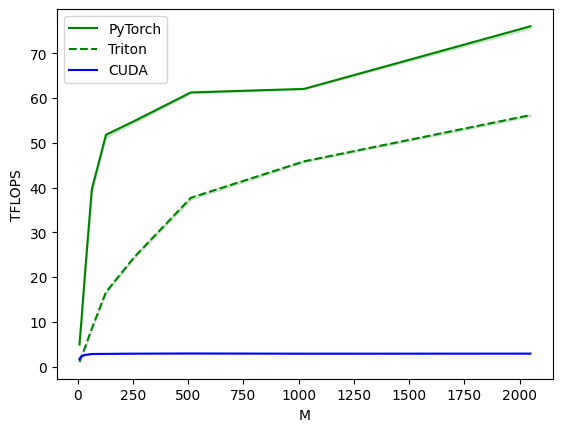

matmul:
        M    PyTorch     Triton      CUDA
0     8.0   4.946113   1.061312  1.702234
1    16.0   9.709037   2.122624  2.269645
2    32.0  20.164923   4.128252  2.608398
3    64.0  39.568906   8.490494  2.826350
4   128.0  51.781532  16.644064  2.852298
5   256.0  54.827503  24.456584  2.900625
6   512.0  61.230717  37.701608  2.941049
7  1024.0  62.022981  45.839389  2.896119
8  2048.0  76.000981  56.158044  2.908356


In [4]:
@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			2 ** i for i in range(3, 12)
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	layer = nn.Linear(4096, 4096)
	vec = torch.randn(M, 4096, device='cuda', dtype=torch.float16)

	quantizer = original_quant.Quantizer()
	quantizer.configure(4, perchannel=True, sym=False, mse=False)
	quantizer.find_params(layer.weight.data, weight=True)
	layer.weight.data = original_quant.quantize(layer.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq)

	cuda_layer = original_quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	cuda_layer.pack(layer, quantizer.scale, quantizer.zero)

	# Convert layer to 16-bit
	layer = layer.half()

	# Convert cuda_layer to Triton
	state_dict = cuda_layer.state_dict()
	state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
	state_dict['bias'] = state_dict['bias'].to(torch.float16, copy=True)
	triton_layer = quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	triton_layer.load_state_dict(state_dict)

	# Move to GPU
	layer = layer.to('cuda')
	cuda_layer = cuda_layer.to('cuda')
	triton_layer = triton_layer.to('cuda')

	if provider == 'torch':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: layer(vec))
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: cuda_layer(vec))
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_layer(vec))
	
	perf = lambda ms: 2 * M * 4096 * 4096 * 1e-12 / (ms * 1e-3)
	return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=True, print_data=True)